<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Prediction_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import feature_importances, CVScores, RFECV
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix

# Loading Dataframe

In [3]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Prediction

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

In [4]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [5]:
print(f"Columns being analysed: {len(TO_USE)}")
df[TO_USE].head()

Columns being analysed: 19


,koi_steff,koi_fpflag_ec,koi_insol,koi_prad,ra,koi_time0bk,koi_depth,koi_impact,koi_slogg,koi_kepmag,koi_fpflag_nt,koi_fpflag_co,koi_period,koi_fpflag_ss,koi_teq,koi_srad,dec,koi_duration,koi_model_snr
0,5455.0,0,93.59,2.26,291.93423,170.538750,615.8,0.146,4.467,15.347,0,0,9.488036,0,793.0,0.927,48.141651,2.95750,35.8
1,5455.0,0,9.11,2.83,291.93423,162.513840,874.8,0.586,4.467,15.347,0,0,54.418383,0,443.0,0.927,48.141651,4.50700,25.8
2,5853.0,0,39.30,14.60,297.00482,175.850252,10829.0,0.969,4.544,15.436,0,0,19.899140,1,638.0,0.868,48.134129,1.78220,76.3
3,5805.0,0,891.96,33.46,285.53461,170.307565,8079.2,1.276,4.564,15.597,0,0,1.736952,1,1395.0,0.791,48.285210,2.40641,505.6
4,6031.0,0,926.16,2.75,288.75488,171.595550,603.3,0.701,4.438,15.509,0,0,2.525592,0,1406.0,1.046,48.226200,1.65450,40.9


# Extracting Dataframe Subset

We extract only those rows which are either positive or negative examples i.e. the `disposition value` is *not* `CANDIDATE`. This is because `CANDIDATE` is the **default value** for all obects of interest picked up by Kepler. The labels `CONFIRMED` and `FALSE POSITIVE` serve as our positive and negative labels

#### Difference between disposition and pdisposition?

We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While `pdisposition` gives us the **most probable labels based on the physical explanation given by the readings**, `disposition` values are based on **the NASA Exoplanet Archive Data**.  

In [6]:
np.unique(df["koi_disposition"].values)

array(['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE'], dtype=object)

In [7]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(6939, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Obtaining X and y

We can encode the categorical labels to 1 and 0 for easier comparison
```
CONFIRMED - 1
FALSE POSITIVE - 0
```

In [8]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [9]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4647
CONFIRMED         2292
Name: koi_disposition, dtype: int64

# Data Visualisation

In [10]:
def getVisualisationPCA(X, y):
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    labels = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in labels]
    plt.grid()
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig("pca.png", dpi=600)
    
    
def getVarianceContribution(X, y):
    cols = X.shape[1]
    x = StandardScaler().fit_transform(X)
    pca = PCA().fit(x)
    variance = pca.explained_variance_ratio_
    s = np.sum(variance)
    p = variance/s
    #print(variance)
    plt.grid()
    plt.bar(list(range(1, cols+1)), p)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.grid()
    plt.show()
    plt.savefig("variance.png", dpi=600)
    
    
def getFeatureCorrelation(X, y):
    visualizer = FeatureCorrelation(labels=TO_USE)
    visualizer.fit(X, y)
    visualizer.show("correlation.png", dpi=600)
    
    
def getPearsonRanking(X):
    visualizer = rank2d(X, features=TO_USE)
    visualizer.show("pearson_ranking.png", dpi=600)
    

def getRadialViz(X, y):
    visualizer = RadViz(classes=[0, 1], features = TO_USE)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show("radial.png", dpi=600)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


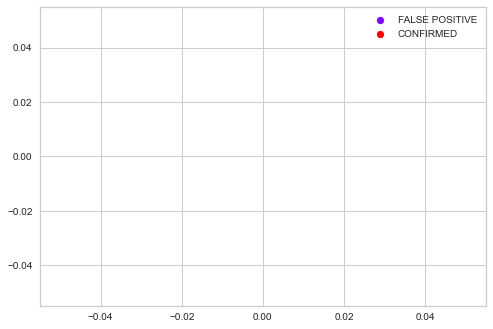

<Figure size 576x396 with 0 Axes>

In [11]:
getVisualisationPCA(X, y)

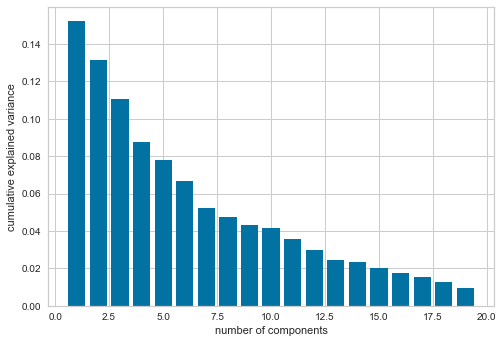

<Figure size 576x396 with 0 Axes>

In [12]:
getVarianceContribution(X, y)

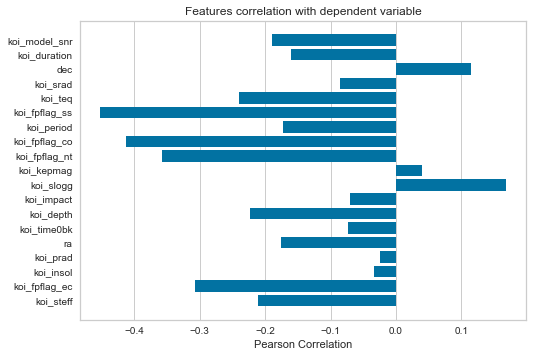

In [13]:
getFeatureCorrelation(X, y)

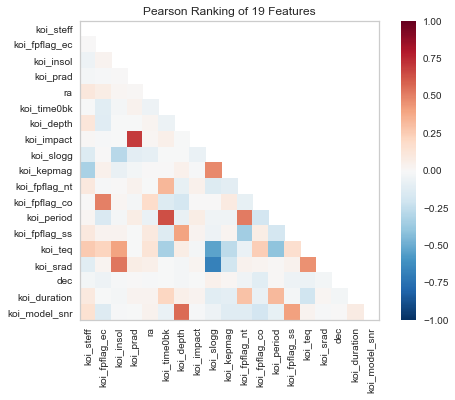

<Figure size 576x396 with 0 Axes>

In [14]:
getPearsonRanking(X)

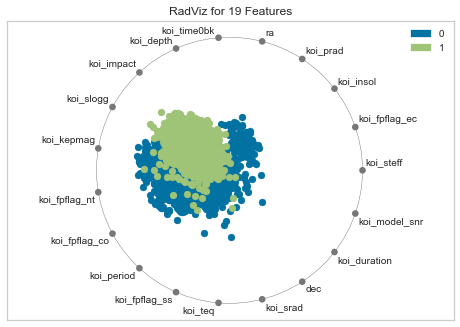

In [15]:
getRadialViz(X, y)

* We can see that our columns are not interdependent and we can use all our columns
* We observe that the two classes are **not** linearly separable, hence a simple Logistic Regression classifier will not do well.
* Most important, we see there is a **class imbalance** present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as 
* SVM
* Random Forests
* AdaBoost

# Splitting into Train and Test sets

* Scale the values to make the models less computationally expensive and convert all the values to the same range
* Split into train and test sets

In [16]:
X = StandardScaler().fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 19), (2290, 19), (4649,), (2290,))

# Evaluation Metric 

Since the dataset is imbalanced, we cannot use accuracy, hence we opt for the following -
* Confusion Matrix
* F1 Score
* Cohen Kappa Score
* Balanced Accuracy Score

In [19]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

# Cross Validation Score

In [20]:
def crossValidationCheck(classifier, X, y, K=10):

    cv = KFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show(f"{classifier}_cv.png", dpi=600)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show(f"{classifier}_learn_curve.png", dpi=600)
    
    cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over Stratified {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show(f"{classifier}_cv_strat.png", dpi=600)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    visualizer.show(f"{classifier}_learn_curve_strat.png", dpi=600)

# Feature Importance

In [21]:
def getFeatureImportance(model, X, y):
    viz = feature_importances(model, X, y, labels=TO_USE)
    viz.fit(X, y)
    viz.show(f"{model}_imp.png", dpi=600)

# Class Predictions

In [22]:
def getClassPredictionError(classifier):
    visualizer = ClassPredictionError(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(f"{classifier}_pred_error.png", dpi=600)
    
def getClassificationReport(classifier):
    visualizer = ClassificationReport(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(f"{classifier}_report.png", dpi=600)
    
def getDiscriminationThreshold(classifier):
    visualizer = DiscriminationThreshold(classifier, exclude=["queue_rate"])
    visualizer.fit(X, y)        
    visualizer.show(f"{classifier}_disc_thresh.png", dpi=600)
    
def getPrecisionRecall(classifier):
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(f"{classifier}_pr.png", dpi=600)
    
def rocCurve(classifier):
    visualizer = ROCAUC(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show(f"{classifier}_roc.png", dpi=600)

# Recursive Feature Elimination

In [23]:
def getFeatureElimination(classifier, X, y):
    visualizer = RFECV(classifier)
    visualizer.fit(X, y)
    visualizer.show(f"{classifier}_feat_elim.png", dpi=600)           

# Saving and Loading Model

In [24]:
def saveModel(model, filename):
    joblib.dump(model, filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

# SVM

In [25]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [26]:
performance(y_test, pred)

F1 Score: 0.9794293297942933
Kappa Score: 0.96934163327601
Accuracy Score: 0.9838579499596449
Confusion Matrix:
[[1521   13]
 [  18  738]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.98      0.98      0.98       756

    accuracy                           0.99      2290
   macro avg       0.99      0.98      0.98      2290
weighted avg       0.99      0.99      0.99      2290



In [27]:
classifier

SVC(random_state=0)

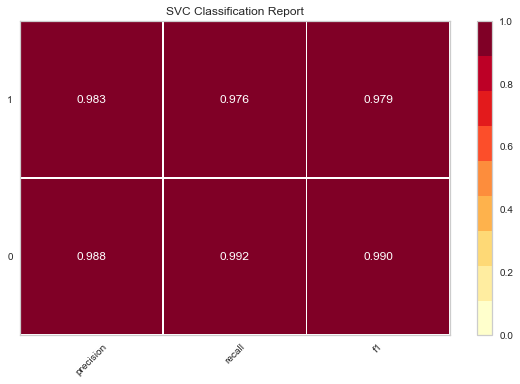

In [28]:
getClassificationReport(classifier)

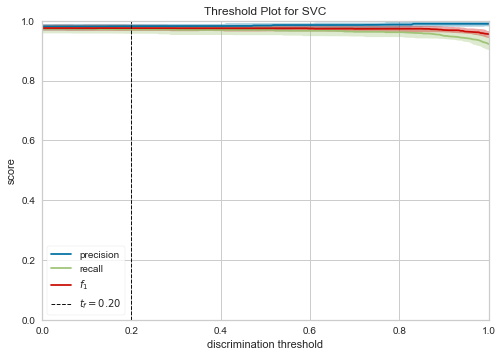

In [29]:
getDiscriminationThreshold(classifier)

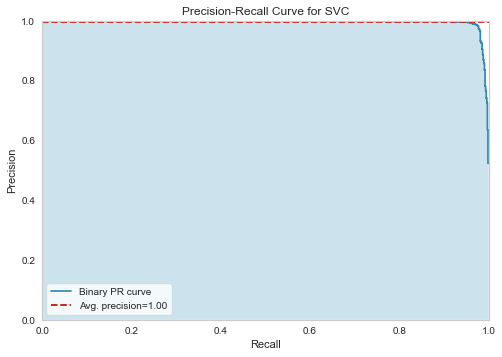

In [30]:
getPrecisionRecall(classifier)

## Checking Cross Validation Score

Average F1 score over 10-Folds: 0.9766139372147696


Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).


Average F1 score over Stratified 10-Folds: 0.977206096029063


Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-312.0, ..., 6558.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 6871 ticks ([-3

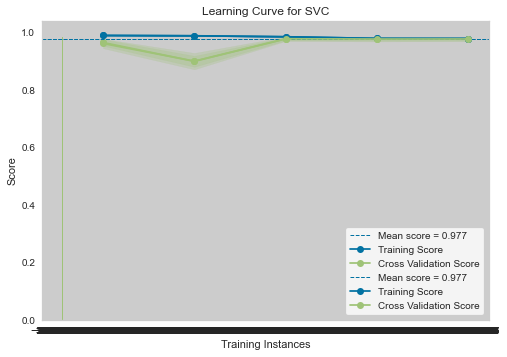

In [31]:
crossValidationCheck(classifier, X, y, K=10)

## Hyperparameter Tuning for SVM

In [32]:
parameters = {
    "C":np.arange(1, 3.05, 0.05),
    "gamma":["scale", "auto"],
    "shrinking":[True, False],
    "tol":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    "class_weight":[None, "balanced"]
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
classifier = GridSearchCV(
    SVC(kernel="rbf", random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 2296 candidates, totalling 11480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 2420 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4820 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 6320 tasks      | elapsed:  2.2min


In [ ]:
classifier.best_score_

In [ ]:
classifier.best_params_

In [ ]:
performance(y_test, classifier.best_estimator_.predict(X_test))

In [ ]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

In [ ]:
saveModel(classifier.best_estimator_, "../model/svm.model")

# Random Forest

In [ ]:
classifier = RandomForestClassifier(random_state=0, n_jobs=-1)#, max_depth=8, n_estimators=400, min_samples_leaf=5)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [ ]:
performance(y_test, pred)

In [ ]:
getClassificationReport(classifier)

In [ ]:
getDiscriminationThreshold(classifier)

In [ ]:
getPrecisionRecall(classifier)

In [ ]:
rocCurve(classifier)

## Checking Cross Validation Score

In [ ]:
crossValidationCheck(classifier, X, y, K=10)

In [ ]:
getFeatureElimination(classifier, X, y)

## Feature Importance

In [ ]:
getFeatureImportance(classifier, X, y)

## Hyperparameter Tuning for Random Forest

In [ ]:
"""parameters = {
    "n_estimators":np.arange(100,700,100),
    "max_depth":[None] + np.arange(1, 10, 1).tolist(),
    #"min_samples_split":np.arange(0, 1.1, 0.1),
    "min_samples_leaf":np.arange(0, 1.1, 0.2),
    "max_features":[None ,"sqrt", "log2"], #+ np.arange(1, 1.1, 0.1).tolist(),
    #"min_weight_fraction_leaf":np.arange(0, 11, 1),
    #"min_impurity_decrease":np.arange(1, 11, 1),
    "class_weight":[None, "balanced", "balanced_subsample"],
    #"max_leaf_nodes":[None] + np.arange(1, 11, 1).tolist(),
    #"ccp_alpha":np.arange(0, 1.1, 0.1)
}

scores = ["f1", "balanced_accuracy"]"""

In [ ]:
saveModel(classifier, "../model/random-forest.model")

# Adaboost

In [ ]:
classifier = AdaBoostClassifier(random_state=0)
classifier.fit(X_train, y_train)

In [ ]:
pred = classifier.predict(X_test)
performance(y_test, pred)

In [ ]:
getClassificationReport(classifier)

In [ ]:
getDiscriminationThreshold(classifier)

In [ ]:
getPrecisionRecall(classifier)

In [ ]:
rocCurve(classifier)

## Checking Cross Validation Score

In [ ]:
crossValidationCheck(classifier, X, y, K=10)

## Feature Elimination

In [ ]:
getFeatureElimination(classifier, X, y)

## Feature Importance

In [ ]:
getFeatureImportance(classifier, X, y)

## Hyperparameter Tuning for AdaBoost

In [ ]:
parameters = {
    "n_estimators":np.arange(70,130,10),
    "learning_rate":np.arange(0.8,1.2,0.05),
    "algorithm":["SAMME", "SAMME.R"],
    "base_estimator":[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=None)
    ]
}

scores = ["f1", "balanced_accuracy"]

In [ ]:
classifier = GridSearchCV(
    AdaBoostClassifier(random_state=0),
    param_grid=parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

In [ ]:
classifier.best_score_

In [ ]:
classifier.best_params_

In [ ]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

In [ ]:
performance(y_test, classifier.best_estimator_.predict(X_test))

In [ ]:
saveModel(classifier.best_estimator_, "../model/adaboost.model")